In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import utils

In [2]:
dataset_dir = os.path.abspath('./COVID-19_Radiography_Dataset')
dest_dir = os.path.abspath('./dataset')

train_dir, test_dir, val_dir = utils.split_dataset(dataset_dir, dest_dir, test_ratio=0.2, val_ratio=0.1)

Ya existen datos de train, test y val.


In [3]:
batch_size = 64

train_set =  torchvision.datasets.ImageFolder(train_dir, transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
print(train_set)

test_set =  torchvision.datasets.ImageFolder(test_dir, transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
print(test_set)

Dataset ImageFolder
    Number of datapoints: 14814
    Root location: /Users/allen/Documents/Msc/Semestre II/Aprendizaje Automatico/proyecto3/dataset/train
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 4232
    Root location: /Users/allen/Documents/Msc/Semestre II/Aprendizaje Automatico/proyecto3/dataset/test
    StandardTransform
Transform: ToTensor()


****************** COVID **************************
Número de canales: 3
Dimensiones: 299 x 299


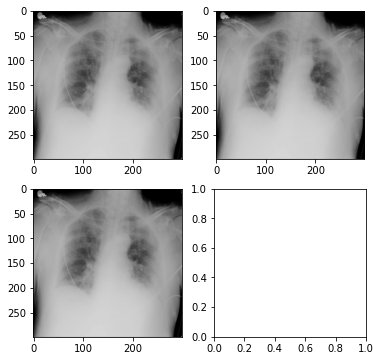

In [4]:
tensor_img, label_idx = train_set[0]
utils.show_img(tensor_img, train_set.classes[label_idx])

### Capa 1:

In [5]:
print('****************** Info Layer 1 **************************')
layer1_in_channels, layer1_img_width, layer1_img_height = tensor_img.shape
print("Dimensiones de entrada:", layer1_img_width, "x", layer1_img_height)
print("Número de canales de entrada:", layer1_in_channels)

layer1_num_filters = 32
print("Número de filtros:", layer1_num_filters)

layer1_kernel_size = 3
print("Dimensiones del kernel:", layer1_kernel_size, "x", layer1_kernel_size)

layer1_stride = 2
print("Tamaño de Stride:", layer1_stride)

layer1_padding = 1
print("Tamaño de Padding:", layer1_padding)

layer1_out_size = utils.size_output_layer(layer1_img_width, layer1_kernel_size, layer1_stride, layer1_padding)
print("Dimensiones de salida:", layer1_out_size, "x", layer1_out_size)

****************** Info Layer 1 **************************
Dimensiones de entrada: 299 x 299
Número de canales de entrada: 3
Número de filtros: 32
Dimensiones del kernel: 3 x 3
Tamaño de Stride: 2
Tamaño de Padding: 1
Dimensiones de salida: 150 x 150


In [6]:
layer1_conv = nn.Conv2d(
        layer1_in_channels,
        layer1_num_filters,
        layer1_kernel_size,
        layer1_stride,
        layer1_padding
)

****************** LAYER 1: AFTER CONVOLUTION **************************
Número de canales: 32
Dimensiones: 150 x 150


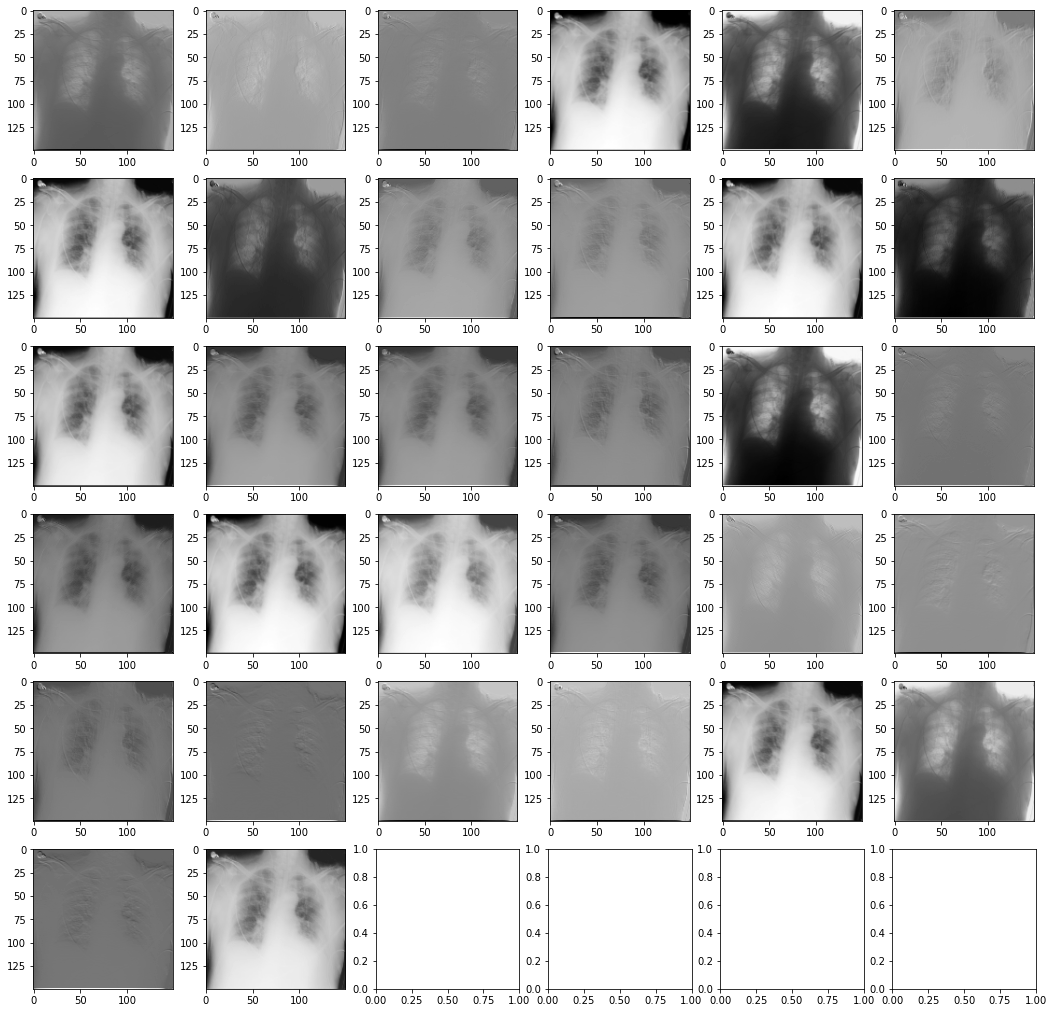

In [7]:
# LAYER 1: Prueba convolución
after_conv = layer1_conv(tensor_img.unsqueeze(0))
utils.show_img(after_conv[0], "LAYER 1: AFTER CONVOLUTION")

****************** LAYER 1: AFTER RELU **************************
Número de canales: 32
Dimensiones: 150 x 150


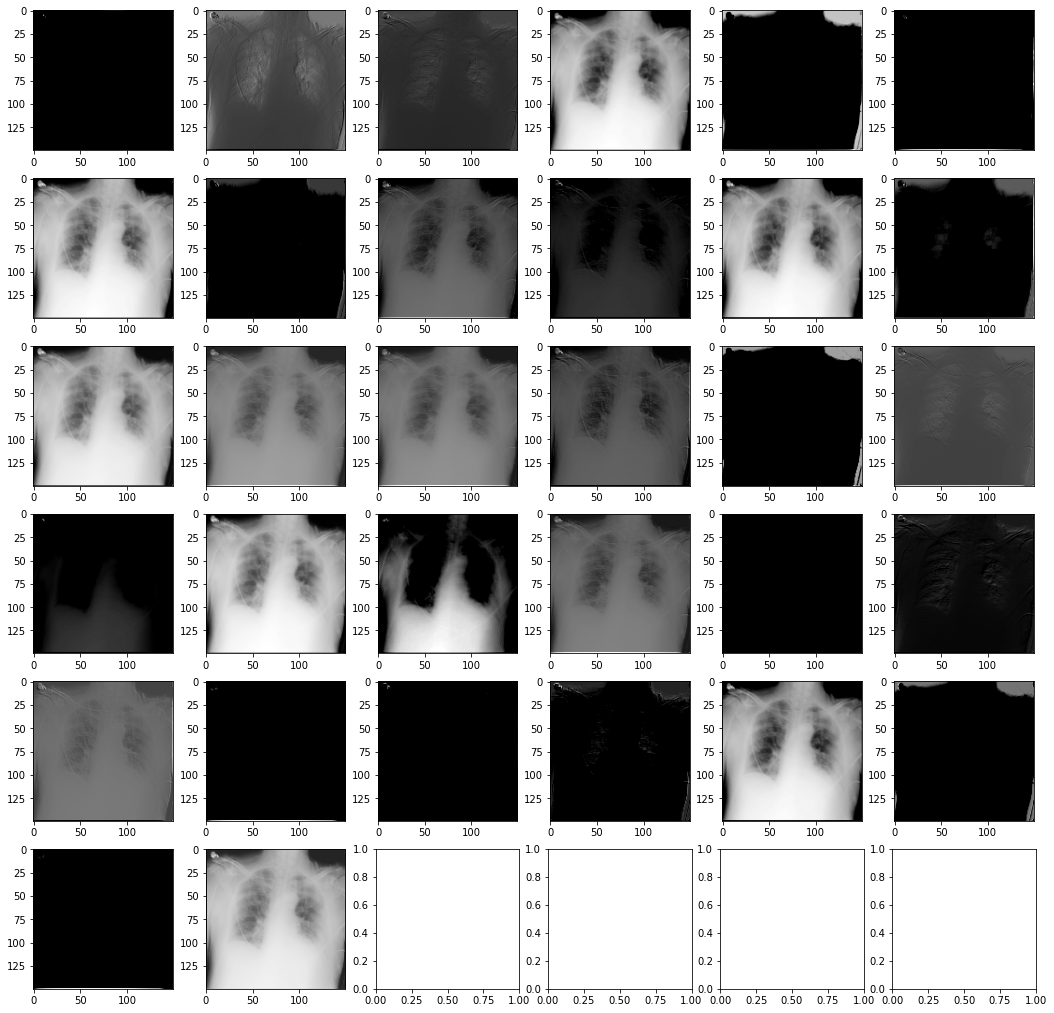

In [8]:
# LAYER 1: Prueba relu
after_relu = nn.ReLU()(after_conv)
utils.show_img(after_relu[0], "LAYER 1: AFTER RELU")

****************** LAYER 1: AFTER MAX POOLING **************************
Número de canales: 32
Dimensiones: 75 x 75


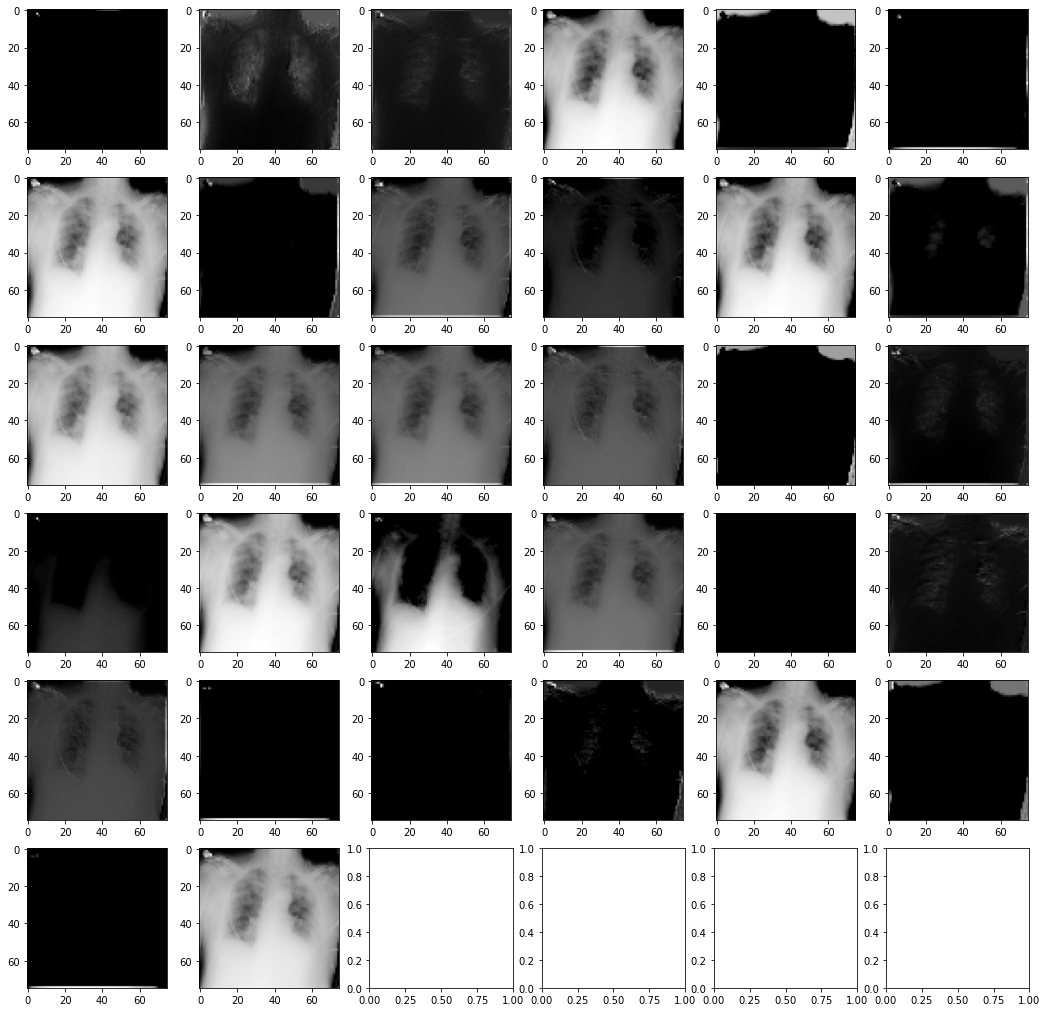

In [9]:
# LAYER 1: Prueba max pooling
after_pool = nn.MaxPool2d(kernel_size=2, stride=2)(after_relu)
utils.show_img(after_pool[0], "LAYER 1: AFTER MAX POOLING")

### Capa 2

In [10]:
print('****************** Info Layer 2 **************************')
layer2_in_channels, layer2_img_width, layer2_img_height = after_pool[0].shape
print("Dimensiones de entrada:", layer2_img_width, "x", layer2_img_height)
print("Número de canales de entrada:", layer2_in_channels)

layer2_num_filters = 64
print("Número de filtros:", layer2_num_filters)

layer2_kernel_size = 2
print("Dimensiones del kernel:", layer2_kernel_size, "x", layer2_kernel_size)

layer2_stride = 2
print("Tamaño de Stride:", layer2_stride)

layer2_padding = 1
print("Tamaño de Padding:", layer2_padding)

layer2_out_size = utils.size_output_layer(layer2_img_width, layer2_kernel_size, layer2_stride, layer2_padding)
print("Dimensiones de salida:", layer2_out_size, "x", layer2_out_size)

****************** Info Layer 2 **************************
Dimensiones de entrada: 75 x 75
Número de canales de entrada: 32
Número de filtros: 64
Dimensiones del kernel: 2 x 2
Tamaño de Stride: 2
Tamaño de Padding: 1
Dimensiones de salida: 38 x 38


In [11]:
layer2_conv = nn.Conv2d(
        layer2_in_channels,
        layer2_num_filters,
        layer2_kernel_size,
        layer2_stride,
        layer2_padding
)

### Model

In [12]:
# Layer 1: Convolutional layer
layer1 = nn.Sequential(
    layer1_conv,
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2)
)

In [13]:
# Layer 2: Convolutional layer
layer2 = nn.Sequential(
    layer2_conv,
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2)
)

In [14]:
output_dim = utils.size_output_layer(layer2_out_size, 2, 2, 0)
print("Dimensiones luego del MaxPool2d:", output_dim)

Dimensiones luego del MaxPool2d: 19


In [15]:
# Layer 3: Linear Classifier
num_classes = 4
classifier = nn.Linear(
    in_features=output_dim * output_dim * layer2_num_filters,
    out_features=num_classes
)

In [16]:
model = utils.CNN()

model.addLayer(layer1)
model.addLayer(layer2)

model.addClassifier(classifier)
print(model)

# Optimizer
learning_rate =  0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


CNN(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=23104, out_features=4, bias=True)
)
